# Quantile-quantile (QQ) scaled climate projections

In [1]:
import glob
import calendar
import sys
import gc

import xarray as xr
from xclim import sdba
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import xesmf as xe
import dask.diagnostics
import cmdline_provenance as cmdprov
import dask
import cmocean
import seaborn as sns
import pandas as pd

sys.path.append('/g/data/wp00/shared_code/qqscale')
import utils

In [2]:
dask.diagnostics.ProgressBar().register()

In [3]:
# Parameters
example_lat = -42.9
example_lon = 147.3
example_month = 6

In [4]:
# Parameters
adjustment_file = "/g/data/wp00/users/dbi599/test_space/pr-qdc-adjustment-factors-multiplicative-monthly-ssr_day_ACCESS-ESM1-5_historical-ssp370_r1i1p1f1_19950101-20141231_20350101-20641231.nc"
qq_file = "/g/data/wp00/users/dbi599/test_space/pr-qdc-multiplicative-monthly-ssr-infileq_day_AGCD-ACCESS-ESM1-5_ssp370_r1i1p1f1_20350101-20641231.nc"
target_q_file = "/g/data/wp00/users/dbi599/test_space/precip-total-ssr-quantiles_AGCD-CSIRO_r005_19900101-20191231_daily.nc"
example_lat = -26.36
example_lon = 152.97
example_month = 5
hist_units = "kg m-2 s-1"
ref_units = "kg m-2 s-1"
target_units = "mm d-1"
output_units = "mm d-1"
hist_var = "pr"
ref_var = "pr"
target_var = "precip"
hist_files = "/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/day/pr/gn/latest/pr_day_ACCESS-ESM1-5_historical_r1i1p1f1_gn_19500101-19991231.nc /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/day/pr/gn/latest/pr_day_ACCESS-ESM1-5_historical_r1i1p1f1_gn_20000101-20141231.nc"
ref_files = "/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp370/r1i1p1f1/day/pr/gn/latest/pr_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_20150101-20641231.nc /g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp370/r1i1p1f1/day/pr/gn/latest/pr_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_20650101-21001231.nc"
target_files = "/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19000101-20220405_daily_space-chunked.zarr"
hist_time_bounds = "1995-01-01 2014-12-31"
ref_time_bounds = "2035-01-01 2064-12-31"
target_time_bounds = "1990-01-01 2019-12-31"


In [5]:
# Required parameters
assert 'hist_var' in locals(), "Must provide an historical variable name (option -p hist_var {name})"
assert 'ref_var' in locals(), "Must provide a reference variable name (option -p ref_var {name})"
assert 'target_var' in locals(), "Must provide a target variable name (option -p target_var {name})"
assert 'hist_units' in locals(), "Must provide historical units (option -p hist_units {units})"
assert 'ref_units' in locals(), "Must provide reference units (option -p ref_units {units})"
assert 'target_units' in locals(), "Must provide target units (option -p target_units {units})"
assert 'output_units' in locals(), "Must provide output units (option -p output_units {units})"
assert 'adjustment_file' in locals(), "Must provide an adjustment factors file (option -p adjustment_file {file path})"
assert 'hist_files' in locals(), """Must provide historical data files (option -p hist_files {"file paths"})"""
assert 'ref_files' in locals(), """Must provide reference data files (option -p ref_files {"file paths"})"""
assert 'target_files' in locals(), """Must provide target data files (option -p target_files {"file paths"})"""
assert 'qq_file' in locals(), "Must provide an qq-scaled data file (option -p qq_file {file path})"
assert 'hist_time_bounds' in locals(), """Must provide time bounds for historical data (option -p hist_time_bounds {"YYYY-MM-DD YYYY-MM-DD"})"""
assert 'ref_time_bounds' in locals(), """Must provide time bounds for reference data (option -p ref_time_bounds {"YYYY-MM-DD YYYY-MM-DD"})"""
assert 'target_time_bounds' in locals(), """Must provide time bounds for target data (option -p target_time_bounds {"YYYY-MM-DD YYYY-MM-DD"})"""

In [6]:
hist_files = hist_files.split()
ref_files = ref_files.split()
target_files = target_files.split()

hist_time_bounds = hist_time_bounds.split()
ref_time_bounds = ref_time_bounds.split()
target_time_bounds = target_time_bounds.split()

In [7]:
point_selection = {'lat': example_lat, 'lon': example_lon}

In [8]:
plot_config = {}
if hist_var == 'tasmin':
    plot_config['regular_cmap'] = cmocean.cm.thermal
    plot_config['diverging_cmap'] = 'RdBu_r'
    plot_config['general_levels'] = [-1, 0.5, 2, 3.5, 5, 6.5, 8, 9.5, 11, 12.5, 14, 15.5, 17, 18.5, 20, 21.5]
    plot_config['af_levels'] = None
    plot_config['difference_levels'] = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
elif hist_var == 'tasmax':
    plot_config['regular_cmap'] = cmocean.cm.thermal
    plot_config['diverging_cmap'] = 'RdBu_r'
    plot_config['general_levels'] = [5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35]
    plot_config['af_levels'] = None
    plot_config['difference_levels'] = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2]
elif hist_var == 'pr':
    plot_config['regular_cmap'] = cmocean.cm.rain
    plot_config['diverging_cmap'] = 'BrBG'
    plot_config['general_levels'] = [0, 0.01, 10, 20, 30, 40, 50, 60, 70, 80, 90]
    plot_config['af_levels'] = [0.125, 0.25, 0.5, 0.67, 0.8, 1, 1.25, 1.5, 2, 4, 8]
    plot_config['difference_levels'] = [-0.55, -0.45, -0.35, -0.25, -0.15, -0.05, 0.05, 0.15, 0.25, 0.35, 0.45, 0.55]
else:
    raise ValueError(f'No plotting configuration defined for {hist_var}')

## Read data

In [9]:
ds_hist = utils.read_data(
    hist_files,
    hist_var,
    time_bounds=hist_time_bounds,
    input_units=hist_units,
    output_units=output_units,
)
ds_hist[hist_var]

<xarray.DataArray 'pr' (time: 7305, lat: 145, lon: 192)>
dask.array<rechunk-merge, shape=(7305, 145, 192), dtype=float32, chunksize=(7305, 145, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1995-01-01T12:00:00 ... 2014-12-31T12:00:00
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Attributes:
    standard_name:  precipitation_flux
    long_name:      Precipitation
    comment:        includes both liquid and solid phases
    units:          mm d-1
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-11-15T17:41:46Z altered by CMOR: replaced missing va...

In [10]:
da_hist = ds_hist[hist_var].sel(point_selection, method='nearest')

In [11]:
ds_ref = utils.read_data(
    ref_files,
    ref_var,
    time_bounds=ref_time_bounds,
    input_units=ref_units,
    output_units=output_units,
)
ds_ref[ref_var]

<xarray.DataArray 'pr' (time: 10958, lat: 145, lon: 192)>
dask.array<mul, shape=(10958, 145, 192), dtype=float32, chunksize=(10958, 145, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2035-01-01T12:00:00 ... 2064-12-31T12:00:00
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Attributes:
    standard_name:  precipitation_flux
    long_name:      Precipitation
    comment:        includes both liquid and solid phases
    units:          mm d-1
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-11-15T10:39:53Z altered by CMOR: replaced missing va...

In [12]:
da_ref = ds_ref[ref_var].sel(point_selection, method='nearest')

In [13]:
ds_adjust = xr.open_dataset(adjustment_file)

In [14]:
ds_target = utils.read_data(
    target_files,
    target_var,
    time_bounds=target_time_bounds,
    input_units=target_units,
    output_units=output_units
)

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [15]:
da_target = ds_target[target_var].sel(point_selection, method='nearest')

In [16]:
ds_target[target_var]

<xarray.DataArray 'precip' (time: 10957, lat: 691, lon: 886)>
dask.array<xarray-precip, shape=(10957, 691, 886), dtype=float32, chunksize=(10957, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
  * time     (time) datetime64[ns] 1990-01-01T09:00:00 ... 2019-12-31T09:00:00
Attributes:
    analysis_time:                 2010-10-23 14:49:46 UTC
    analysis_version_number:       3.01
    cell_methods:                  time: sum
    frequency:                     daily
    length_scale_for_analysis:     80.0
    long_name:                     Daily precipitation
    number_of_stations_reporting:  2757
    source:                        Interpolated surface observations
    standard_name:                 lwe_thickness_of_precipitation_amount
    units:                         mm d-1

In [17]:
target_q = xr.open_dataset(target_q_file)

In [18]:
ds_qq = xr.open_dataset(qq_file)

In [19]:
da_qq = ds_qq[target_var].sel(point_selection, method='nearest')

In [20]:
#qq_q = utils.get_quantiles(ds_qq[target_var], ds_adjust['quantiles'].data)
#qq_q = qq_q.compute()

In [21]:
lat_min_qq = ds_qq['lat'].values.min()
lat_max_qq = ds_qq['lat'].values.max()
lon_min_qq = ds_qq['lon'].values.min()
lon_max_qq = ds_qq['lon'].values.max()

In [22]:
print(lat_min_qq, lat_max_qq, lon_min_qq, lon_max_qq)

-44.5 -10.0 112.0 156.25


## Quantile mapping

In [23]:
def quantile_month_plot(da, ax, cmap_type, levels=None, extend='both', point=None, title=None):
    """Create two dimensional month/quantile plot"""
    
    assert cmap_type in ['regular', 'diverging']
    
    if 'lat' in da.dims:
        point_selection = {'lat': example_lat, 'lon': example_lon}
    else:
        point_selection = {}
    quantiles = da.sel(point_selection, method='nearest')
    
    cmap = plot_config[f'{cmap_type}_cmap']
    kwargs = {}
    if levels:
        kwargs['levels'] = levels
    elif cmap_type == 'diverging':
        abs_max = np.max(np.abs(quantiles.values))
        vmax = abs_max
        vmin = -1 * abs_max
        kwargs['vmax'] = vmax
        kwargs['vmin'] = vmin
    
    quantiles.transpose('month', 'quantiles').plot(ax=ax, cmap=cmap, extend=extend, **kwargs)
    
    yticks = np.arange(1,13)
    ytick_labels = [calendar.month_abbr[i] for i in yticks]
    ax.set_yticks(yticks, ytick_labels)
    ax.invert_yaxis()
    if title:
        ax.set_title(title)

In [24]:
def quantile_spatial_plot(
    da, month, cmap_type, lat_bounds=None, lon_bounds=None, levels=None,
):
    """Spatial plot of the 10th, 50th and 90th percentile"""
    
    da_selection = da.sel({'quantiles': [.1, .5, .9], 'month': month}, method='nearest')
    if lat_bounds:
        lat_min, lat_max = lat_bounds
        da_selection = da_selection.sel(lat=slice(lat_min, lat_max))
    if lon_bounds:
        lon_min, lon_max = lon_bounds
        da_selection = da_selection.sel(lon=slice(lon_min, lon_max))
        
    cmap = plot_config[f'{cmap_type}_cmap']
    kwargs = {}
    if levels:
        kwargs['levels'] = levels
    elif cmap_type == 'diverging':
        abs_max = np.max(np.abs(da_selection.values))
        vmax = abs_max
        vmin = -1 * abs_max
        kwargs['vmax'] = vmax
        kwargs['vmin'] = vmin
        
    p = da_selection.plot(
        col='quantiles',
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        figsize=[20, 5.5],
        subplot_kws={'projection': ccrs.PlateCarree(),},
        **kwargs,
    )
    for ax in p.axes.flat:
        ax.coastlines()
        ax.plot(example_lon, example_lat, 'go', zorder=5, transform=ccrs.PlateCarree())
    plt.suptitle(calendar.month_name[month])
    plt.show()

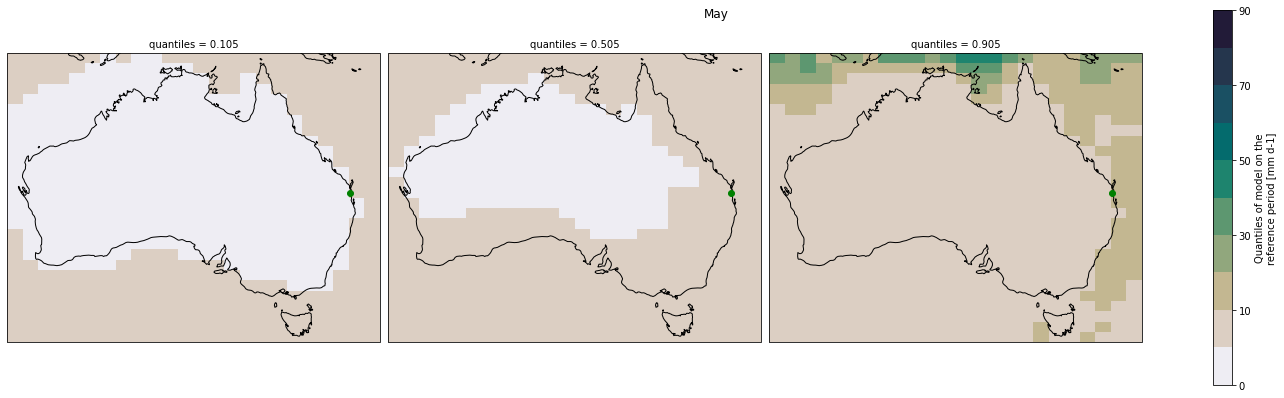

In [25]:
if 'lat' in ds_adjust.dims:
    quantile_spatial_plot(
        ds_adjust['hist_q'],
        example_month,
        'regular',
        levels=plot_config['general_levels'],
        lat_bounds=[lat_min_qq, lat_max_qq],
        lon_bounds=[lon_min_qq, lon_max_qq],
    )

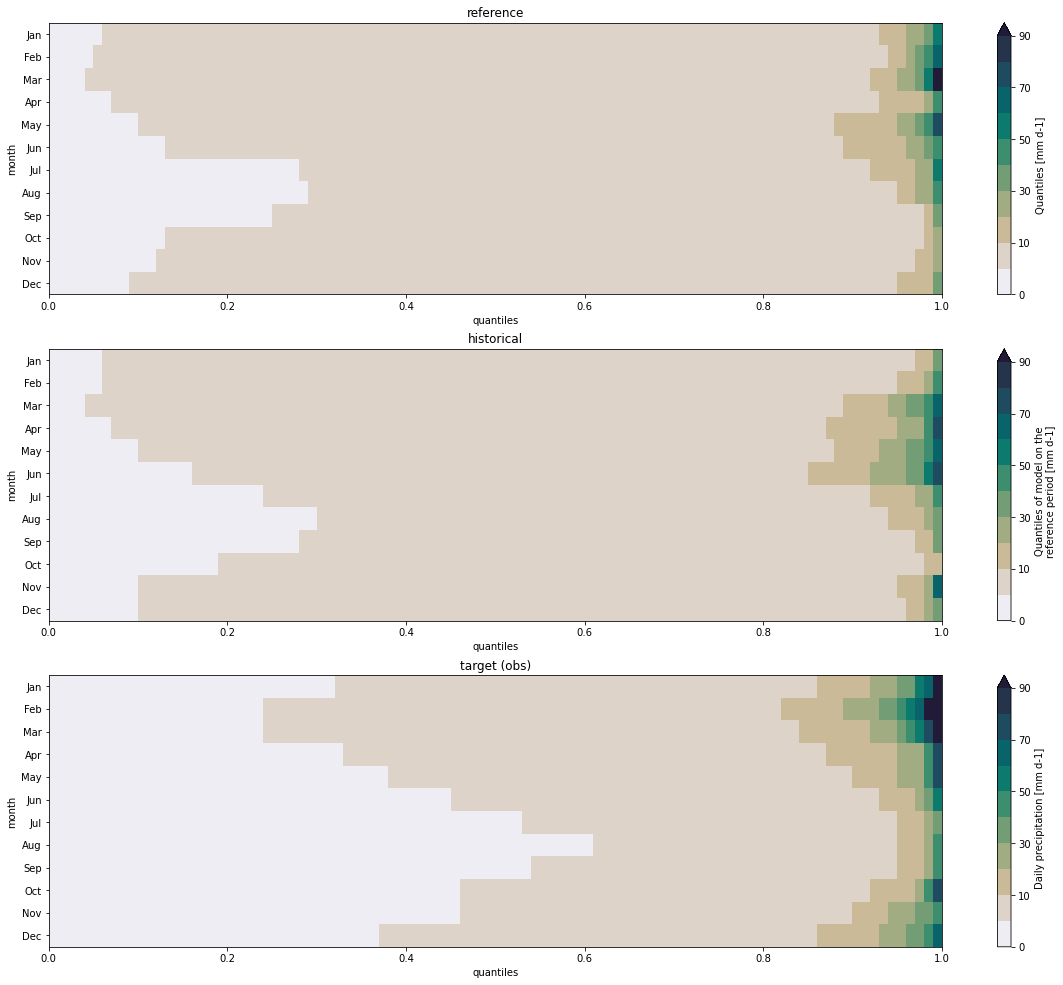

In [26]:
fig = plt.figure(figsize=[20, 17])
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

quantile_month_plot(
    ds_adjust['ref_q'],
    ax1,
    'regular',
    levels=plot_config['general_levels'],
    title='reference',
    extend='max',
)

quantile_month_plot(
    ds_adjust['hist_q'],
    ax2,
    'regular',
    levels=plot_config['general_levels'],
    title='historical',
    extend='max',
)

quantile_month_plot(
    target_q[target_var],
    ax3,
    'regular',
    levels=plot_config['general_levels'],
    title='target (obs)',
    extend='max',
)

plt.show()

In [27]:
df_hist = pd.DataFrame(da_hist[da_hist['time'].dt.month == example_month].values, columns=[hist_var])

[########################################] | 100% Completed |  4.6s


In [28]:
df_ref = pd.DataFrame(da_ref[da_ref['time'].dt.month == example_month].values, columns=[hist_var])

[########################################] | 100% Completed |  7.3s


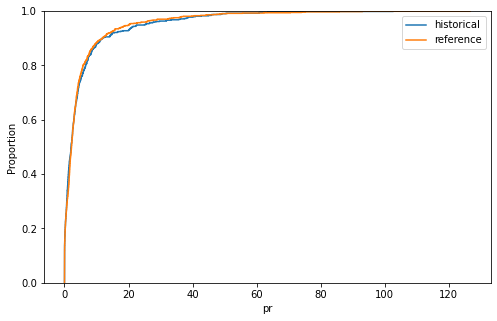

In [29]:
fig = plt.figure(figsize=[8, 5])
ax1 = fig.add_subplot(111)

sns.ecdfplot(ax=ax1, data=df_hist, x=hist_var, color='tab:blue', label='historical')
sns.ecdfplot(ax=ax1, data=df_ref, x=hist_var, color='tab:orange', label='reference')
ax1.legend()
#ax1.plot([13.9, 13.9], [0, 0.5], color='0.5')
#ax1.plot([5, 13.9], [0.5, 0.5], color='0.5')
#ax1.plot([13.9, 15], [0.5, 0.5], color='0.5', linestyle=':')
#ax1.plot([15, 15], [0, 0.5], color='0.5', linestyle=':')
#ax1.set_xlim(8, 20)
plt.show()

So for a X day in the observational record, the empirical quantile mapping works as follows:
1. Find the probability that temperature is exceeded in the historical data
2. Find the temperature corresponding to that probability in the reference data
3. That temperature is the new qq-scaled value for that day in the observational record (the "adjustment" factor is the difference between X and that new temperature)

In other words, for a given temperature in the observational record the xclim software uses `hist_q` to look up the quantile corresponding to that temperature and then uses `af` to find the adjustment factor for the quantile.

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  4.5s


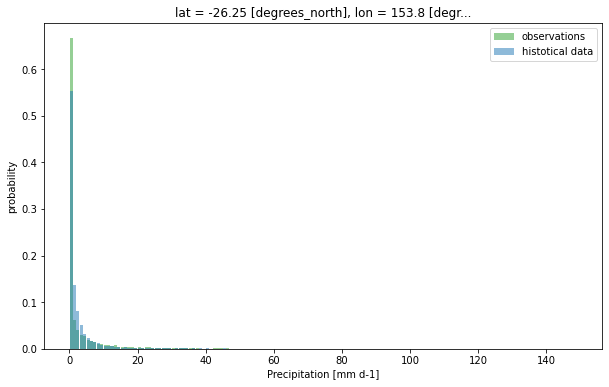

In [30]:
fig = plt.figure(figsize=[10, 6])

bins = np.arange(0, 150, 1)

da_target.plot.hist(
    bins=bins,
    density=True,
    label='observations',
    facecolor='tab:green',
    alpha=0.5,
    rwidth=0.9,
)

da_hist.plot.hist(
    bins=bins,
    density=True,
    label='histotical data',
    facecolor='tab:blue',
    alpha=0.5,
    rwidth=0.9,
)
plt.ylabel('probability')
#plt.xlim(5, 25)
plt.legend()
plt.show()

An issue here is that the temperature variability at this grid point in the observations is much greater than in the model. This means there are days in the observations that can't be linked to a corresponding historical probability. In this case, the adjustment factor at the first or last quantile (depending on whether it's a very cold or very hot day) is used. 

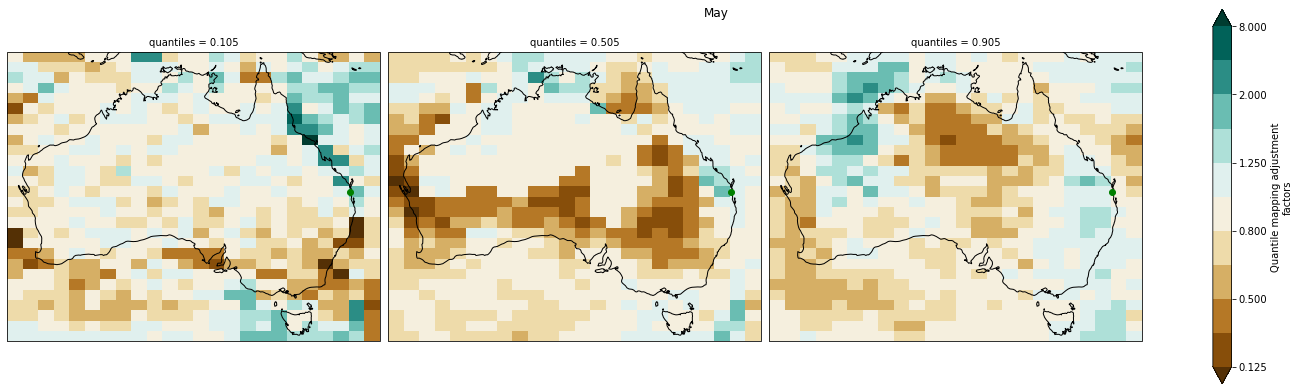

In [31]:
if 'lat' in ds_adjust.dims:
    quantile_spatial_plot(
        ds_adjust['af'],
        example_month,
        'diverging',
        levels=plot_config['af_levels'],
        lat_bounds=[lat_min_qq, lat_max_qq],
        lon_bounds=[lon_min_qq, lon_max_qq],
    )

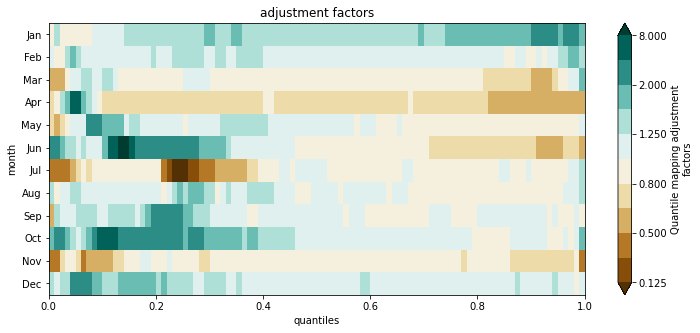

In [32]:
fig = plt.figure(figsize=[12, 5])
ax1 = fig.add_subplot(111)

quantile_month_plot(
    ds_adjust['af'],
    ax1,
    'diverging',
    levels=plot_config['af_levels'],
    title='adjustment factors'
)

plt.show()

## QQ-scaled data

In [33]:
model_sel = {'lat': slice(lat_min_qq, lat_max_qq), 'lon': slice(lon_min_qq, lon_max_qq)}

In [34]:
hist_clim = ds_hist[hist_var].mean('time', keep_attrs=True)
ref_clim = ds_ref[ref_var].mean('time', keep_attrs=True)
target_clim = ds_target[target_var].mean('time', keep_attrs=True)
qq_clim = ds_qq[target_var].mean('time', keep_attrs=True)

In [35]:
if len(hist_clim['lat']) != len(qq_clim['lat']):
    regridder = xe.Regridder(hist_clim, qq_clim, "bilinear")
    hist_clim = regridder(hist_clim)

if len(ref_clim['lat']) != len(qq_clim['lat']):
    regridder = xe.Regridder(ref_clim, qq_clim, "bilinear")
    ref_clim = regridder(ref_clim)
    
if len(target_clim['lat']) != len(qq_clim['lat']):
    regridder = xe.Regridder(target_clim, qq_clim, "bilinear")
    target_clim = regridder(target_clim)

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/dask/array/core.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/dask/array/core.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key i

In [36]:
hist_ref_mean_diff = ref_clim - hist_clim
hist_ref_mean_diff = hist_ref_mean_diff.compute()

[########################################] | 100% Completed | 14.0s


In [37]:
qq_mean_change = qq_clim - target_clim
qq_mean_change = qq_mean_change.compute()

[########################################] | 100% Completed |  5min 25.3s


In [38]:
difference = qq_mean_change - hist_ref_mean_diff

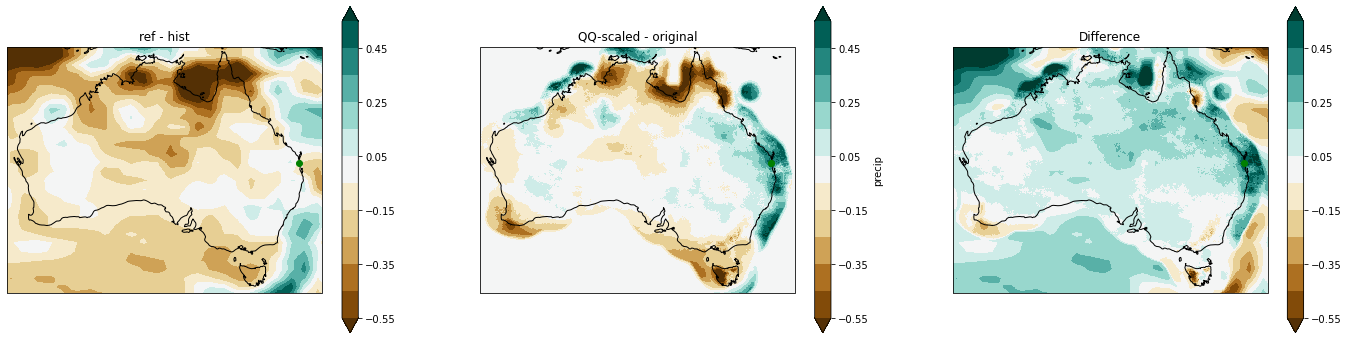

In [39]:
fig = plt.figure(figsize=[24, 6])

ax1 = fig.add_subplot(131, projection=ccrs.PlateCarree())
hist_ref_mean_diff.plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap=plot_config['diverging_cmap'],
    levels=plot_config['difference_levels'],
    extend='both'
)
ax1.set_title('ref - hist')

ax2 = fig.add_subplot(132, projection=ccrs.PlateCarree())
qq_mean_change.plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap=plot_config['diverging_cmap'],
    levels=plot_config['difference_levels'],
    extend='both'
)
ax2.set_title('QQ-scaled - original')

ax3 = fig.add_subplot(133, projection=ccrs.PlateCarree())
difference.plot(
    ax=ax3,
    transform=ccrs.PlateCarree(),
    cmap=plot_config['diverging_cmap'],
    levels=plot_config['difference_levels'],
    extend='both'
)
ax3.set_title('Difference')

for ax in [ax1, ax2, ax3]:
    ax.coastlines()
    ax.plot(example_lon, example_lat, 'go', zorder=5, transform=ccrs.PlateCarree())
xmin, xmax = ax3.get_xlim()
ymin, ymax = ax3.get_ylim()
ax1.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())
ax2.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

plt.show()

[########################################] | 100% Completed |  5.1s
[########################################] | 100% Completed |  7.7s
[########################################] | 100% Completed |  0.6s


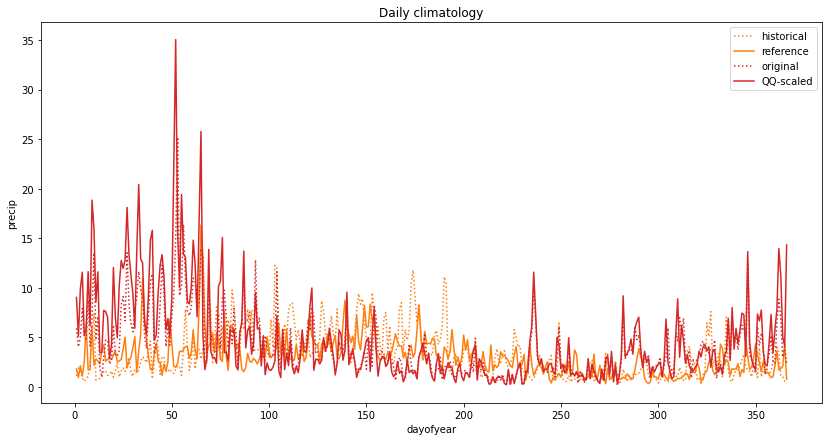

In [40]:
fig, ax = plt.subplots(figsize=[14, 7])
ds_hist[hist_var].sel(point_selection, method='nearest').groupby("time.dayofyear").mean().plot(label="historical", color='tab:orange', linestyle=':')
ds_ref[ref_var].sel(point_selection, method='nearest').groupby("time.dayofyear").mean().plot(label="reference", color='tab:orange')
ds_target[target_var].sel(point_selection, method='nearest').groupby("time.dayofyear").mean().plot(label="original", color='tab:red', linestyle=':')
ds_qq[target_var].sel(point_selection, method='nearest').groupby("time.dayofyear").mean().plot(label="QQ-scaled", color='tab:red')
plt.legend()
plt.title('Daily climatology')
plt.show()

[########################################] | 100% Completed |  0.1s


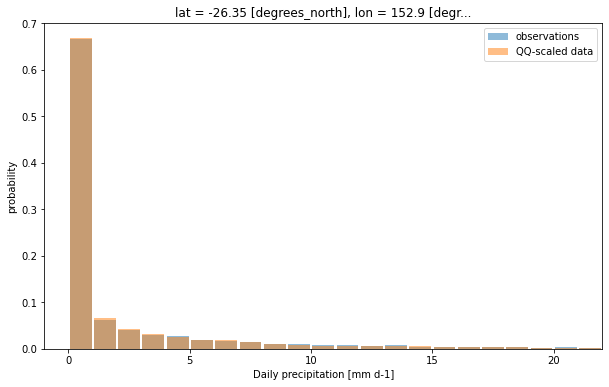

In [41]:
fig = plt.figure(figsize=[10, 6])

bins = np.arange(0, 150, 1)
    
da_target.plot.hist(
    bins=bins,
    density=True,
    label='observations',
    facecolor='tab:blue',
    alpha=0.5,
    rwidth=0.9,
)
da_qq.plot.hist(
    bins=bins,
    density=True,
    label='QQ-scaled data',
    facecolor='tab:orange',
    alpha=0.5,
    rwidth=0.9,
)
plt.ylabel('probability')
#plt.ylim(0, 0.005)
plt.xlim(-1, 22)
plt.legend()
plt.show()

In [42]:
def build_df(target_data, qq_data, target_var, qq_var):
    """Build a dataframe for analysis"""
    
    df_target = target_data.to_dataframe().drop(['lat', 'lon'], axis=1).reset_index()
    df_qq = qq_data.to_dataframe().drop(['lat', 'lon'], axis=1).reset_index()
    df = df_target.copy()
    df = df.rename(columns={target_var: f'orig_{target_var}'})
    df[f'new_{target_var}'] = df_qq[qq_var]
    df['af'] = df[f'new_{target_var}'] / df[f'orig_{target_var}']
    df['change'] = df[f'new_{target_var}'] - df[f'orig_{target_var}']
    df['month'] = df['time'].dt.month.values
    df = df.sort_values('change', ascending=True).reset_index(drop=True)
    df['change_rank'] = df.index.to_series()
    
    return df

In [43]:
obs_change_df = build_df(da_target, da_qq, target_var, target_var)
obs_change_df

[########################################] | 100% Completed |  0.1s


,time,orig_precip,new_precip,af,change,month,change_rank
0,2009-04-14 09:00:00,172.936523,101.892504,0.589190,-71.044019,4,0
1,2014-04-14 09:00:00,101.146484,59.594517,0.589190,-41.551967,4,1
2,2015-04-03 09:00:00,76.192383,47.178528,0.619203,-29.013855,4,2
3,2015-04-02 09:00:00,77.116211,50.384493,0.653358,-26.731718,4,3
4,2012-03-18 09:00:00,74.896484,51.742763,0.690857,-23.153722,3,4
...,...,...,...,...,...,...,...
10952,2013-01-27 09:00:00,186.759766,283.737524,1.519265,96.977759,1,10952
10953,2017-03-15 09:00:00,135.991211,239.865156,1.763828,103.873945,3,10953
10954,1997-03-06 09:00:00,168.324219,273.047936,1.622155,104.723717,3,10954
10955,2011-01-10 09:00:00,190.052734,298.026152,1.568123,107.973417,1,10955


/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


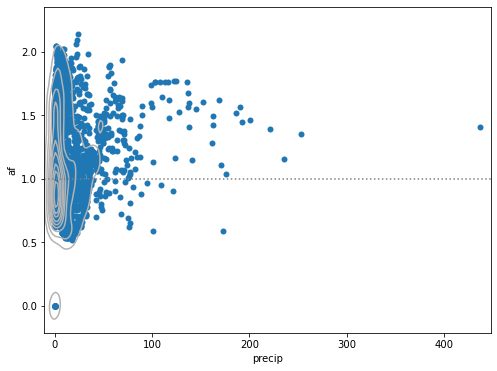

In [44]:
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(111)

sns.scatterplot(ax=ax, data=obs_change_df, x=f'orig_{target_var}', y='af', linewidth=0)
sns.kdeplot(ax=ax, data=obs_change_df, x=f'orig_{target_var}', y='af', color='0.7', linewidth=1)

ax.set_xlabel(target_var)
ax.set_ylabel('af')
ax.axhline(1.0, color='0.5', linestyle=':')
plt.show()

In [45]:
ds_hist_long = utils.read_data(
    hist_files,
    hist_var,
    time_bounds=['1985-01-01', '2014-12-31'],
    input_units=hist_units,
    output_units=output_units,
)
da_hist_long = ds_hist_long[hist_var].sel(point_selection, method='nearest')

In [46]:
qm_cmip = sdba.EmpiricalQuantileMapping.from_dataset(
    ds_adjust.sel(point_selection, method='nearest')[['af', 'hist_q']]
)

In [47]:
qm_cmip

EmpiricalQuantileMapping(group=Grouper(add_dims=[], name='time.month', window=1), kind='*')

In [48]:
da_cmip_qq = qm_cmip.adjust(da_hist_long, extrapolation='constant', interp='linear')
da_cmip_qq = da_cmip_qq.compute()

[########################################] | 100% Completed | 12.6s


In [49]:
cmip_change_df = build_df(da_hist_long, da_cmip_qq, hist_var, 'scen')

[########################################] | 100% Completed |  7.1s


In [50]:
cmip_mean_change = float(hist_ref_mean_diff.sel(point_selection, method='nearest').values)
cmip_mean_change

-0.07125639915466309

In [51]:
cmip_change_df['change'].mean()

0.030947532830137077

In [52]:
obs_change_df['change'].mean()

0.5592698972643699

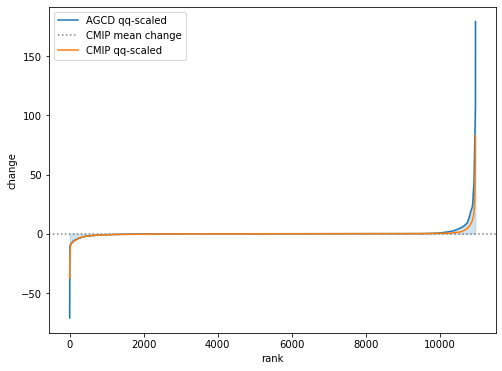

In [53]:
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(111)

sns.lineplot(ax=ax, data=obs_change_df, x='change_rank', y='change', color='tab:blue', label='AGCD qq-scaled')
ax.fill_between(x=obs_change_df['change_rank'], y1=obs_change_df['change'], alpha=0.2, color='tab:blue')

ax.axhline(cmip_mean_change, color='0.5', linestyle=':', label='CMIP mean change')

sns.lineplot(ax=ax, data=cmip_change_df, x='change_rank', y='change', color='tab:orange', label='CMIP qq-scaled')

ax.legend()
ax.set_xlabel('rank')
ax.set_ylabel('change')
plt.show()

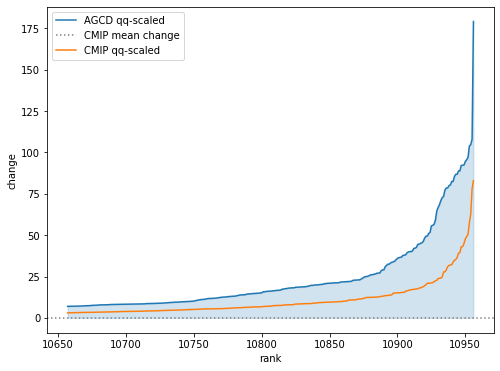

In [54]:
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(111)

sns.lineplot(ax=ax, data=obs_change_df[-300:], x='change_rank', y='change', color='tab:blue', label='AGCD qq-scaled')
ax.fill_between(x=obs_change_df['change_rank'][-300:], y1=obs_change_df['change'][-300:], alpha=0.2, color='tab:blue')

ax.axhline(cmip_mean_change, color='0.5', linestyle=':', label='CMIP mean change')

sns.lineplot(ax=ax, data=cmip_change_df[-300:], x='change_rank', y='change', color='tab:orange', label='CMIP qq-scaled')

ax.legend()
ax.set_xlabel('rank')
ax.set_ylabel('change')
plt.show()

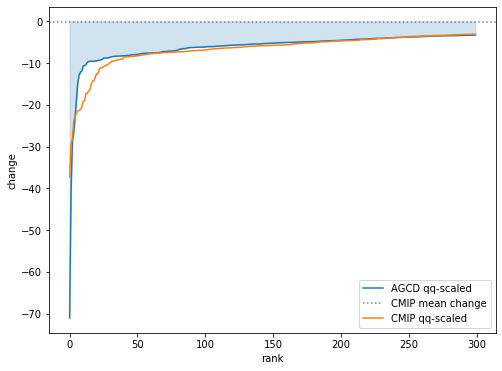

In [55]:
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(111)

sns.lineplot(ax=ax, data=obs_change_df[0:300], x='change_rank', y='change', color='tab:blue', label='AGCD qq-scaled')
ax.fill_between(x=obs_change_df['change_rank'][0:300], y1=obs_change_df['change'][0:300], alpha=0.2, color='tab:blue')

ax.axhline(cmip_mean_change, color='0.5', linestyle=':', label='CMIP mean change')

sns.lineplot(ax=ax, data=cmip_change_df[0:300], x='change_rank', y='change', color='tab:orange', label='CMIP qq-scaled')

ax.legend()
ax.set_xlabel('rank')
ax.set_ylabel('change')
plt.show()

In [56]:
hist_q_annual = utils.get_quantiles(da_hist, ds_adjust['quantiles'].data, timescale='annual')
hist_q_annual = hist_q_annual.compute()

[########################################] | 100% Completed |  4.6s


In [57]:
ref_q_annual = utils.get_quantiles(da_ref, ds_adjust['quantiles'].data, timescale='annual')
ref_q_annual = ref_q_annual.compute()

[########################################] | 100% Completed |  7.1s


In [58]:
target_q_annual = utils.get_quantiles(da_target, ds_adjust['quantiles'].data, timescale='annual')
target_q_annual = target_q_annual.compute()

[########################################] | 100% Completed |  0.1s


In [59]:
qq_q_annual = utils.get_quantiles(da_qq, ds_adjust['quantiles'].data, timescale='annual')
qq_q_annual = qq_q_annual.compute()

In [74]:
def plot_quantile_comparison(month):
    """Plot quantile comparison.
    
    month can be 'annual' or an integer month
    
    """
    
    fig = plt.figure(figsize=[15, 5])
    ax1 = fig.add_subplot(122)
    ax2 = fig.add_subplot(121)

    if month == 'annual':
        title = 'annual'
        obs_data = target_q_annual.values
        qq_data = qq_q_annual.values
        hist_data = hist_q_annual.values
        future_data = ref_q_annual.values
        quantiles = target_q_annual['quantiles'].data * 100
    else:
        title = calendar.month_name[month]
        selection['month'] = month
        obs_data = target_q.sel(point_selection, method='nearest').values
        qq_data = qq_q.sel(point_selection, method='nearest').values
        hist_data = ds_adjust['hist_q'].sel(point_selection, method='nearest').values
        future_data = ds_adjust['ref_q'].sel(point_selection, method='nearest').values
        quantiles = target_q['quantiles'].data * 100
        
    ax1.bar(quantiles, obs_data, alpha=0.5, label='observations')
    ax1.bar(quantiles, qq_data, alpha=0.5, label='qq-scaled data')
    ax2.bar(quantiles, hist_data, alpha=0.5, label='historical')
    ax2.bar(quantiles, future_data, alpha=0.5, label='ssp370')

    ax1.set_xlim(70, 100)
    ax1.set_ylim(0, 110)
    ax1.grid()
    ax1.legend()
    ax1.set_xlabel('quantile')

    ax2.set_xlim(70, 100)
    ax2.set_ylim(0, 110)
    ax2.grid()
    ax2.legend()
    ax2.set_ylabel('rainfall (mm/day)')
    ax2.set_xlabel('quantile')

    plt.suptitle(title)
    plt.show()

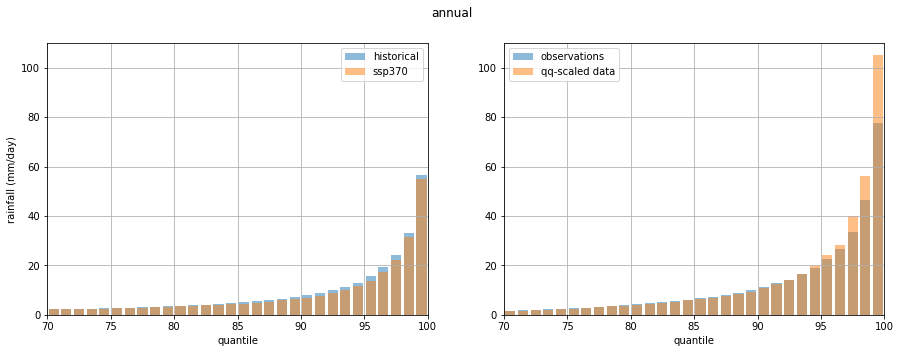

In [75]:
plot_quantile_comparison('annual')

In [62]:
#ds_target_ssr = utils.read_data(
#    '/g/data/wp00/users/dbi599/test_space/precip-total-ssr_AGCD-CSIRO_r005_19900101-20191231_daily.nc',
#    target_var,
#    time_bounds=target_time_bounds,
#    input_units=target_units,
#    output_units=output_units
#)

In [63]:
#target_q_ssr = utils.get_quantiles(ds_target_ssr[target_var], ds_adjust['quantiles'].data)

Check if the rank order of days changes after qq-scaling...

In [64]:
obs_rank_order = obs_change_df.sort_values(f'orig_{target_var}', ascending=False).reset_index(drop=True)

In [65]:
obs_rank_order

,time,orig_precip,new_precip,af,change,month,change_rank
0,1992-02-22 09:00:00,437.139648,616.330098,1.409916,179.190449,2,10956
1,1999-02-09 09:00:00,253.428711,342.276151,1.350582,88.847440,2,10945
2,2007-08-24 09:00:00,235.227539,271.543784,1.154388,36.316245,8,10901
3,1992-02-21 09:00:00,220.933594,307.780086,1.393089,86.846492,2,10944
4,2012-02-25 09:00:00,200.163086,292.317609,1.460397,92.154523,2,10947
...,...,...,...,...,...,...,...
10952,1992-07-31 09:00:00,0.000000,0.000000,NaN,0.000000,7,6093
10953,1992-08-01 09:00:00,0.000000,0.000000,NaN,0.000000,8,6092
10954,1992-07-08 09:00:00,0.000000,0.000000,NaN,0.000000,7,6091
10955,1992-07-07 09:00:00,0.000000,0.000000,NaN,0.000000,7,6090


In [66]:
obs_rank_order.sort_values(f'new_{target_var}', ascending=False)[0:20]

,time,orig_precip,new_precip,af,change,month,change_rank
0,1992-02-22 09:00:00,437.139648,616.330098,1.409916,179.190449,2,10956
1,1999-02-09 09:00:00,253.428711,342.276151,1.350582,88.847440,2,10945
3,1992-02-21 09:00:00,220.933594,307.780086,1.393089,86.846492,2,10944
6,2011-01-10 09:00:00,190.052734,298.026152,1.568123,107.973417,1,10955
4,2012-02-25 09:00:00,200.163086,292.317609,1.460397,92.154523,2,10947
7,2013-01-27 09:00:00,186.759766,283.737524,1.519265,96.977759,1,10952
5,1999-02-02 09:00:00,192.403320,277.868601,1.444199,85.465280,2,10942
11,1997-03-06 09:00:00,168.324219,273.047936,1.622155,104.723717,3,10954
2,2007-08-24 09:00:00,235.227539,271.543784,1.154388,36.316245,8,10901
15,2012-03-05 09:00:00,152.202148,244.499551,1.606413,92.297403,3,10948
